In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, accuracy_score
import pickle

In [2]:
# importing the csv file and converting it into a dataframe
phi_df = pd.read_csv("/content/PhiUSIIL_Phishing_URL_Dataset.csv")
# displaying the entire columns for visibility
pd.set_option('display.max_columns', None)
phi_df.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,LineOfCode,LargestLineLength,HasTitle,Title,DomainTitleMatchScore,URLTitleMatchScore,HasFavicon,Robots,IsResponsive,NoOfURLRedirect,NoOfSelfRedirect,HasDescription,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasSocialNet,HasSubmitButton,HasHiddenFields,HasPasswordField,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,0.061933,3,1,0,0,0.0,18,0.581,0,0.0,0,0,0,1,0.032,1,558,9381,1,à¸‚à¹ˆà¸²à¸§à¸ªà¸” à¸‚à¹ˆà¸²à¸§à¸§à¸±à¸™à¸™à¸µ...,0.000000,0.000000,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,0.050207,2,1,0,0,0.0,9,0.391,0,0.0,0,0,0,2,0.087,1,618,9381,1,johannes gutenberg-universitÃ¤t mainz,55.555556,55.555556,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,0.064129,2,2,0,0,0.0,15,0.517,0,0.0,0,0,0,2,0.069,1,467,682,1,voice fm southampton,46.666667,46.666667,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,0.057606,3,1,0,0,0.0,13,0.500,0,0.0,0,0,0,1,0.038,1,6356,26824,1,home page: seminars in fetal and neonatal medi...,0.000000,0.000000,0,1,1,0,0,0,1,12,0,1,1,1,0,0,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,0.059441,3,1,0,0,0.0,20,0.606,0,0.0,0,0,0,1,0.030,1,6089,28404,1,fundaciÃ³n rewilding argentina,100.000000,100.000000,0,1,1,1,1,1,0,2,0,1,1,1,0,1,1,0,1,244,15,34,72,1,85,1


In [3]:
phi_df.shape

(235795, 56)

In [4]:
phi_df.isnull().sum()

FILENAME                      0
URL                           0
URLLength                     0
Domain                        0
DomainLength                  0
IsDomainIP                    0
TLD                           0
URLSimilarityIndex            0
CharContinuationRate          0
TLDLegitimateProb             0
URLCharProb                   0
TLDLength                     0
NoOfSubDomain                 0
HasObfuscation                0
NoOfObfuscatedChar            0
ObfuscationRatio              0
NoOfLettersInURL              0
LetterRatioInURL              0
NoOfDegitsInURL               0
DegitRatioInURL               0
NoOfEqualsInURL               0
NoOfQMarkInURL                0
NoOfAmpersandInURL            0
NoOfOtherSpecialCharsInURL    0
SpacialCharRatioInURL         0
IsHTTPS                       0
LineOfCode                    0
LargestLineLength             0
HasTitle                      0
Title                         0
DomainTitleMatchScore         0
URLTitle

In [5]:
phi_df.dropna(inplace=True)

In [6]:
phi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  object 
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               235795 non-null  int64  
 13  HasObfuscation

In [7]:
phi_df.columns

Index(['FILENAME', 'URL', 'URLLength', 'Domain', 'DomainLength', 'IsDomainIP',
       'TLD', 'URLSimilarityIndex', 'CharContinuationRate',
       'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain',
       'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio',
       'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL',
       'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL',
       'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL',
       'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'LargestLineLength',
       'HasTitle', 'Title', 'DomainTitleMatchScore', 'URLTitleMatchScore',
       'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect',
       'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame',
       'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton',
       'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto',
       'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef',
       'NoOfEmptyRef', 'NoOf

In [8]:
phi_df.describe()

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,LineOfCode,LargestLineLength,HasTitle,DomainTitleMatchScore,URLTitleMatchScore,HasFavicon,Robots,IsResponsive,NoOfURLRedirect,NoOfSelfRedirect,HasDescription,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasSocialNet,HasSubmitButton,HasHiddenFields,HasPasswordField,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
count,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,2.357950e+05,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000
mean,34.573095,21.470396,0.002706,78.430778,0.845508,0.260423,0.055747,2.764456,1.164758,0.002057,0.024861,0.000138,19.428919,0.515946,1.881011,0.028616,0.062241,0.029403,0.025056,2.340198,0.063309,0.782625,1141.900443,1.278953e+04,0.861261,50.131427,52.122098,0.361768,0.266541,0.624513,0.133438,0.040107,0.440183,0.221765,1.588638,0.043987,0.456570,0.414301,0.377799,0.102263,0.127089,0.237007,0.023474,0.486775,26.075689,6.333111,10.522305,65.071113,2.377629,49.262516,0.571895
std,41.314153,9.150793,0.051946,28.976055,0.216632,0.251628,0.010587,0.599739,0.600969,0.045306,1.876249,0.003817,29.090330,0.123315,11.886695,0.070897,0.934704,0.193505,0.836448,3.527603,0.032393,0.412461,3419.950513,1.522011e+05,0.345675,49.676981,49.600564,0.480513,0.442151,0.484249,0.340048,0.196210,0.496410,3.870540,5.762561,0.205067,0.498111,0.492602,0.484838,0.302994,0.333074,0.425247,0.151403,0.499826,79.411815,74.866296,22.312192,176.687539,17.641097,161.027430,0.494805
min,13.000000,4.000000,0.000000,0.155574,0.000000,0.000000,0.001083,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.200000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,16.000000,0.000000,57.024793,0.680000,0.005977,0.050747,2.000000,1.000000,0.000000,0.000000,0.000000,10.000000,0.435000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.038000,1.000000,18.000000,2.000000e+02,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,27.000000,20.000000,0.000000,100.000000,1.000000,0.079963,0.057970,3.000000,1.000000,0.000000,0.000000,0.000000,14.000000,0.519000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.050000,1.000000,429.000000,1.090000e+03,1.000000,75.000000,100.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2.000000,6.000000,12.000000,0.000000,10.000000,1.000000
75%,34.000000,24.000000,0.000000,100.000000,1.000000,0.522907,0.062875,3.000000,1.000000,0.000000,0.000000,0.000000,20.000000,0.594000,0.000000,0.000000,0.000000,0.000000,0.000

Cleaning

In [9]:
# removing the .txt from the contents of the filename column
phi_df['FILENAME'] = phi_df['FILENAME'].str.replace('.txt', '')
phi_df['FILENAME'].head()

0    521848
1     31372
2    597387
3    554095
4    151578
Name: FILENAME, dtype: object

In [10]:
phi_df['FILENAME'].dtypes

dtype('O')

In [11]:
# checking for unique values of the label column
phi_df['label'].unique()

array([1, 0])

In [12]:
# checking whether there is class imbalance with the label column
phi_df['label'].value_counts()

label
1    134850
0    100945
Name: count, dtype: int64

In [13]:
# showing unique values for the TLD column
phi_df['TLD'].unique()

array(['com', 'de', 'uk', 'org', 'in', 'ie', 'hu', 'ru', 'gq', 'es', 'jp',
       'guru', 'app', 'io', 'club', 'fr', 'au', 'today', 'cloud', 'br',
       'pt', 'co', 'lt', 'ca', 'xyz', 'sk', 'pl', 'dk', 'dev', 'ga',
       'edu', 'space', 'ws', '123', 'cf', 'rs', 'games', 'nl', 'me',
       'net', 'life', 'ua', 'id', 'mx', 'asia', 'store', 'nz', 'eus',
       'qa', 'fi', 'ch', 'site', 'shop', 'hr', 'cz', 'im', 'ee', 'sg',
       'travel', 'tz', 'top', 'info', 'tokyo', 'at', 'gr', 'cc', 'tv',
       'online', 'lk', 'review', 'us', 'bar', 'link', 'ng', 'cl', 'ar',
       'one', 'ph', 'tr', 'mil', 'se', '94', 'live', 'cn', 'ir', 'it',
       'gd', 'eu', 'win', 'no', 'su', 'gov', 'bg', 'ro', 'kr', 'eg',
       'biz', 'il', 'page', 'pm', 'sh', 'pk', 'my', 'quest', 'be', 'sa',
       'tk', 'vip', 'agency', 'cyou', 'kz', 'uy', 'network', '128', 'ml',
       'hk', 'media', 'az', 'aero', 'news', 'lu', 'is', 'coop', 'art',
       'download', 'si', 'fm', 'bt', 'am', 'finance', 'mn', 'kh', 'ug',
 

In [14]:
# encoding the TLD column using label encoding
phi_df ['TLD'] = LabelEncoder().fit_transform(phi_df['TLD'])

In [15]:
# dropping categorical columns
phi_df = phi_df.drop(['Domain', 'FILENAME', 'URL', 'Title'], axis=1)

In [16]:
# separating the dataset to feature and target variables
X = phi_df.drop('label', axis=1)
y = phi_df['label']

In [17]:
# spliting the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

In [18]:
# feature subset selection to create a sparse model
k =20
selector = SelectKBest(f_classif, k=k)
X_train_kbest = selector.fit_transform(X_train, y_train)

In [19]:
X_train_kbest.shape

(47159, 20)

In [20]:
X_test_kbest = selector.transform(X_test)

In [21]:
# defining the xgboost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

In [22]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'subsample': [0.7, 0.8, 1.0]
}

In [23]:
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

In [24]:
# Fit the model
grid_search.fit(X_train_kbest, y_train)

# Best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters found: ", best_params)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}


In [25]:
# Predict on the test set
y_pred = best_model.predict(X_test_kbest)

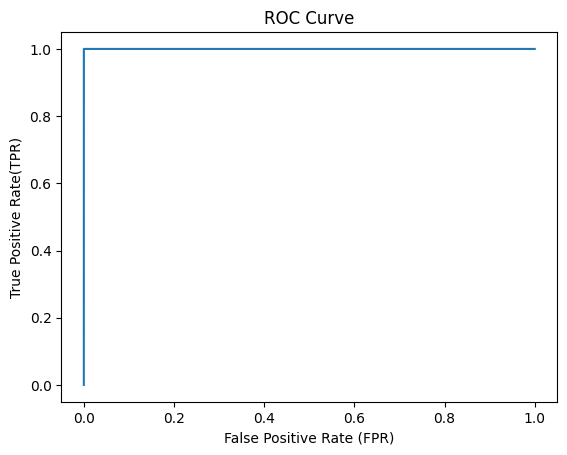

In [26]:
# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC Curve')
plt.show()

In [27]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 99.99%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     80719
           1       1.00      1.00      1.00    107917

    accuracy                           1.00    188636
   macro avg       1.00      1.00      1.00    188636
weighted avg       1.00      1.00      1.00    188636



In [28]:
# saving the model into a pickle
saved_model = 'xgboost_model.pkl'
with open(saved_model, 'wb') as file:
  pickle.dump(best_model, file)